# Create Time Graph - ArcGIS Image Servce: Get Samples

## Imports

In [1]:
import requests
import json

import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime

## Retrieve Image Service Base URL

- To retrieve the POWER Monthly Meteorology Image Service URL navigate to: gis.earthdata.nasa.gov
- Search for "POWER Monthly Meteorology"
- Click on the "Imagery Layer"
  - 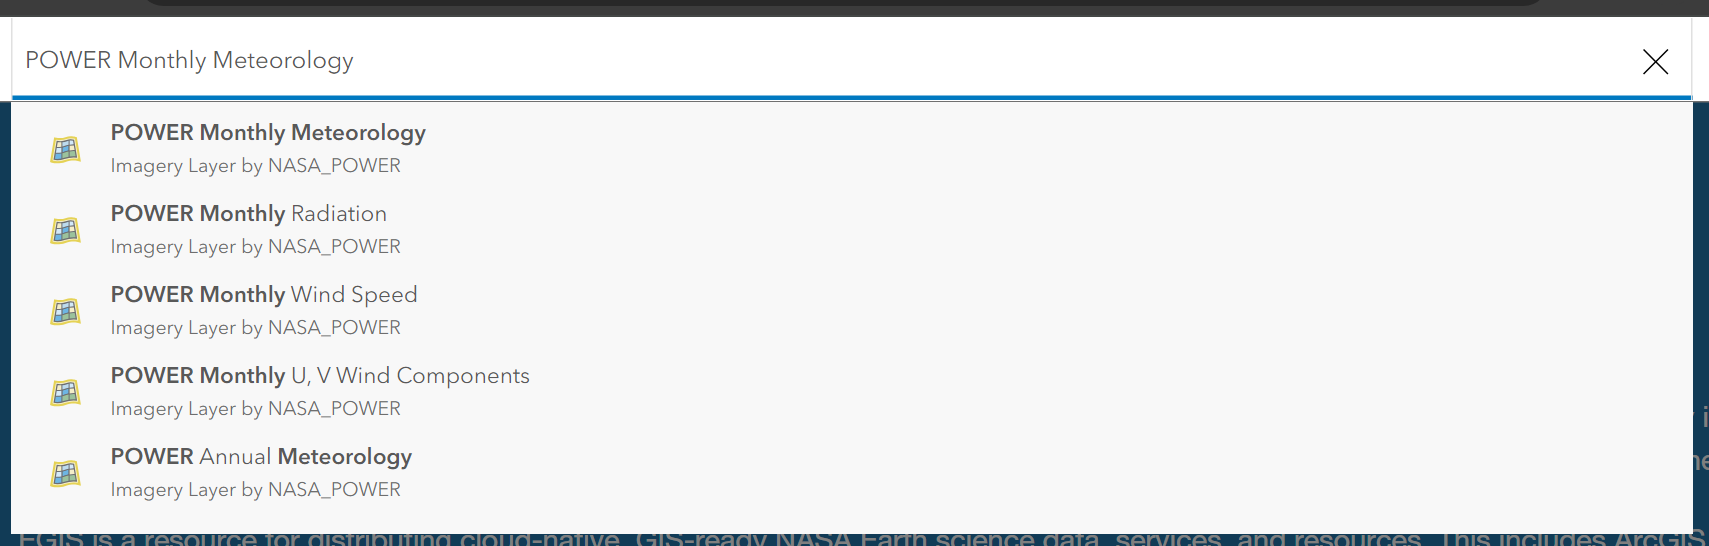
- Scroll down to and copy the URL
  - 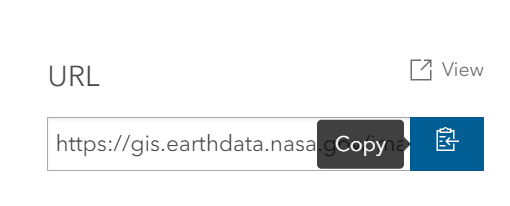

In [2]:
base_url = 'https://gis.earthdata.nasa.gov/image/rest/services/POWER/POWER_901_MONTHLY_METEOROLOGY_UTC/ImageServer'


## Investigate Image Service Multidimensional Information

In [10]:
# Build url to retrieve the Multidimensional Information as a JSON
multidimensional_info = base_url + '/multidimensionalInfo?f=pjson'

# Send the request for Multidimensional Information
multidimensional_get = requests.get(multidimensional_info)

# Reset the content of the request as a JSON
multidimensional_content = multidimensional_get.json()

# You can view the full Multidimensional Information by:
print(json.dumps(multidimensional_content, indent=2))

# Filter JSON to output only the Variables
variables = multidimensional_content['multidimensionalInfo']['variables']
short_names = [var.get('name') for var in variables]
long_names = [var.get('attributes').get('long_name') for var in variables]
full_names = list(zip(short_names, long_names))
print(full_names[:])

{
  "multidimensionalInfo": {
    "variables": [
      {
        "name": "CDD10",
        "unit": "degree-day",
        "statistics": [
          {
            "min": 0,
            "max": 983.875,
            "mean": 185.51287766218204,
            "standardDeviation": 219.7556383867018,
            "median": 19.291666666666668,
            "mode": 0,
            "skipX": 1,
            "skipY": 1,
            "count": 130999680
          }
        ],
        "histograms": [
          {
            "size": 256,
            "min": 0,
            "max": 983.875,
            "counts": [
              63251410,
              597197,
              569419,
              510682,
              441153,
              421407,
              407343,
              376730,
              371850,
              346617,
              357586,
              331528,
              325893,
              316648,
              314514,
              313091,
              300903,
              297897,
          

## CURRENT NOTEBOOK

JESTER:

Possible TODO: Also, the data looks noisy, would a decomposed or shorter time series version be useful?  For example, could do a seasonal decomposition to get the trend, seasonality and noise?  I'm no scientist, but this seems like data that might work well with that sort of visualization.

## Generating a graph of one variable over time

### User Inputs

In [39]:
# Use the same Base Image Service URL as above
print(base_url)

# Choose Variable to Investigate
variable_name = "T2M"  # Example: "T2M"

# Set Time Range to Investigate
start_date_time_str = "1983-01-01 00:00:00" #in 'YYYY-MM-DD HH:MM:SS' format
end_date_time_str = "2022-12-31 23:59:59" #in 'YYYY-MM-DD HH:MM:SS' format

# Define function that converts datetime strings (in 'YYYY-MM-DD HH:MM:SS' format) to milliseconds since epoch
def convert_to_milliseconds(date_time_str: str) -> int:
    dt = datetime.strptime(date_time_str, '%Y-%m-%d %H:%M:%S')
    milliseconds_since_epoch = int(dt.timestamp() * 1000)
    return milliseconds_since_epoch

# Convert user input dates to milliseconds since epoch and confirm conversion
start_time = convert_to_milliseconds(start_date_time_str)
end_time = convert_to_milliseconds(end_date_time_str)
print(start_time)
print(end_time)

https://gis.earthdata.nasa.gov/image/rest/services/POWER/POWER_901_MONTHLY_METEOROLOGY_UTC/ImageServer
410245200000
1672549199000


### Get response from API

In [40]:
# API URL construction
get_samples_url = base_url + '/getSamples/'
parameters = {
    "geometry": "0,0",
    "geometryType": "esriGeometryPoint",
    "sampleDistance": "",
    "sampleCount": "",
    "mosaicRule": f'{{"multidimensionalDefinition":[{{"variableName":"{variable_name}"}}]}}',
    "pixelSize": "",
    "returnFirstValueOnly": "false",
    "interpolation": "RSP_BilinearInterpolation",
    "outFields": "",
    "sliceId": "",
    "time": f"{start_time},{end_time}",
    "f": "pjson"
}

# Make the request to the API
response = requests.get(get_samples_url, params=parameters)
data = response.json()

# Confirm output
print(json.dumps(data, indent=2))

{
  "samples": [
    {
      "location": {
        "x": 0,
        "y": 0,
        "spatialReference": {
          "wkid": 4326,
          "latestWkid": 4326
        }
      },
      "locationId": 0,
      "value": "300.093750000",
      "resolution": 0.5,
      "attributes": {
        "T2M": "300.093750000",
        "StdTime": 412819200000,
        "StdTime_Max": 412819200000,
        "Variables": "T2M",
        "Dimensions": "StdTime"
      }
    },
    {
      "location": {
        "x": 0,
        "y": 0,
        "spatialReference": {
          "wkid": 4326,
          "latestWkid": 4326
        }
      },
      "locationId": 0,
      "value": "300.632812500",
      "resolution": 0.5,
      "attributes": {
        "T2M": "300.632812500",
        "StdTime": 415238400000,
        "StdTime_Max": 415238400000,
        "Variables": "T2M",
        "Dimensions": "StdTime"
      }
    },
    {
      "location": {
        "x": 0,
        "y": 0,
        "spatialReference": {
          "wkid":

### Format as DataFrame

In [41]:
# Extract relevant information into a DataFrame
samples = [
    {
        "StdTime": sample["attributes"]["StdTime"],
        variable_name: float(sample["attributes"][variable_name])
    }
    for sample in data["samples"] if "attributes" in sample
]

df = pd.DataFrame(samples)

### Visualize in Line Graph

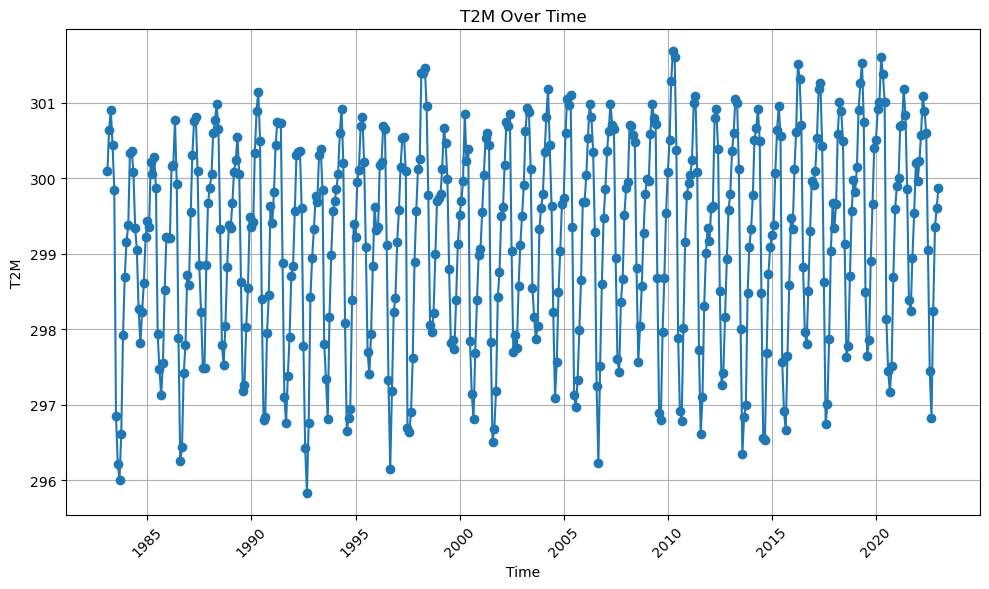

In [42]:
# Convert StdTime from Unix timestamp (milliseconds) to datetime
df['StdTime'] = pd.to_datetime(df['StdTime'], unit='ms')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df['StdTime'], df[variable_name], marker='o', linestyle='-')
plt.title(f'{variable_name} Over Time')
plt.xlabel('Time')
plt.ylabel(variable_name)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Create Map - ArcGIS Image Servce: Export Image

In [48]:
import folium
from folium.raster_layers import ImageOverlay

# Create a map centered at a given latitude and longitude
m = folium.Map(location=[0, 0], zoom_start=2,)  # Centered on a global view crs="EPSG4326"

# Parameters for the Export Image request
variable_name = "T2M"  # Example variable
#image_date_time_str = "2022-01-01 23:59:59"
#time_milliseconds = convert_to_milliseconds(image_date_time_str)
time_milliseconds = "349747200000"
bbox = "-180%2C-90%2C180%2C90"  # Example bounding box for global coverage
format_string = "jpgpng"
size = ""  # Example size, adjust as needed
imageSR = ""
bboxSR = ""

# Construct the Export Image URL
export_image_url = f"https://gis.earthdata.nasa.gov/image/rest/services/POWER/POWER_901_MONTHLY_METEOROLOGY_UTC/ImageServer/exportImage?bbox={bbox}&bboxSR={bboxSR}&size={size}&imageSR={imageSR}&time={time_milliseconds}&format={format}&pixelType=F64&noData=&noDataInterpretation=esriNoDataMatchAny&interpolation=RSP_BilinearInterpolation&compression=&compressionQuality=&bandIds=&sliceId=&mosaicRule=%7B%22multidimensionalDefinition%22%3A%5B%7B%22variableName%22%3A%22{variable_name}%22%7D%5D%7D&renderingRule=&adjustAspectRatio=true&validateExtent=false&lercVersion=1&compressionTolerance=&f=image"

print(export_image_url)

### Start of Jesters example code
#NOTE: This is probably easier for the user to undestand than one really long string.  Python can turn a dictionary into API endpoint parameters.
import urllib
api_endpoint = "https://gis.earthdata.nasa.gov/server/rest/services/POWER/POWER_901_MONTHLY_METEOROLOGY_UTC/ImageServer/exportImage?"
args = {
    "bbox": bbox,
    "bboxSR": bboxSR,
    "size": size,
    "imageSR": imageSR,
    "time": time_milliseconds,
    "format": format_string,
    "pixelType": "F64",
    "noData": "",
    "noDataInterpretation": "esriNoDataMatchAny",
    "interpolation": "RSP_BilinearInterpolation",
    "compression": "",
    "compressionQuality": "",
    "bandIds": "",
    "sliceId": "",
    f"mosaicRule": f"%7B%22multidimensionalDefinition%22%3A%5B%7B%22variableName%22%3A%22{variable_name}%22%7D%5D%7D",
    "renderingRule": "",
    "adjustAspectRatio": "true",
    "validateExtent": "false",
    "lercVersion": "1",
    "compressionTolerance": "",
    "f": "image"
}
url = api_endpoint + urllib.parse.urlencode(args)
### End of Jesters example code

# Add ImageOverlay to the map
ImageOverlay(
    image=export_image_url,
    bounds=[[-90, -180], [90, 180]],
    opacity=0.5,
).add_to(m)

# Save the map as an HTML file
m.save('map_with_image_overlay.html')

# Display the map in Jupyter Notebook or JupyterLab
m

https://gis.earthdata.nasa.gov/image/rest/services/POWER/POWER_901_MONTHLY_METEOROLOGY_UTC/ImageServer/exportImage?bbox=-180%2C-90%2C180%2C90&bboxSR=&size=&imageSR=&time=349747200000&format=<built-in function format>&pixelType=F64&noData=&noDataInterpretation=esriNoDataMatchAny&interpolation=RSP_BilinearInterpolation&compression=&compressionQuality=&bandIds=&sliceId=&mosaicRule=%7B%22multidimensionalDefinition%22%3A%5B%7B%22variableName%22%3A%22T2M%22%7D%5D%7D&renderingRule=&adjustAspectRatio=true&validateExtent=false&lercVersion=1&compressionTolerance=&f=image


In [44]:
.

SyntaxError: invalid syntax (1933637684.py, line 1)